In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import random
import numpy as np

## Task 1

#### Dataset Preparation

In [2]:
def rotate_image(pil_img, angle):
    return pil_img.rotate(angle)

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

indices = [i for i, (img, label) in enumerate(mnist_train) if label in [1, 2]]
filtered_data = torch.utils.data.Subset(mnist_train, indices)

angles = list(range(0, 360, 30))

rotated_images = []
rotated_labels = []

for i in range(len(filtered_data)):
    img_tensor, label = filtered_data[i]
    pil_img = transforms.ToPILImage()(img_tensor)
    for angle in angles:
        rotated_pil = rotate_image(pil_img, angle)
        rotated_tensor = transforms.ToTensor()(rotated_pil)
        rotated_images.append(rotated_tensor)
        rotated_labels.append(label)

rotated_images = torch.stack(rotated_images)

class RotatedMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

rotated_dataset = RotatedMNISTDataset(rotated_images, rotated_labels)
print("Total rotated samples:", len(rotated_dataset))

Total rotated samples: 152400


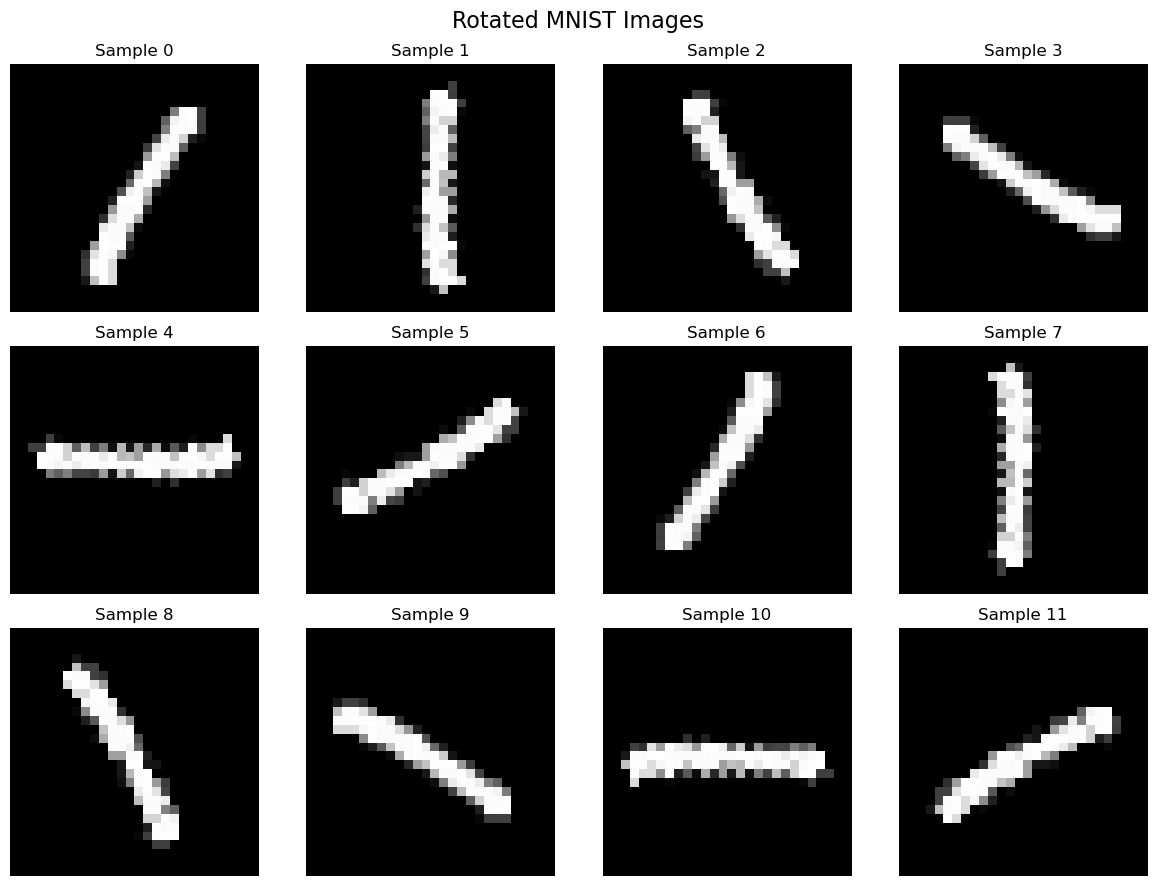

In [3]:
num_images = 12
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for idx in range(num_images):
    img = rotated_images[idx]
    axes[idx].imshow(img.squeeze(), cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f"Sample {idx}")

plt.suptitle("Rotated MNIST Images", fontsize=16)
plt.tight_layout()
plt.show()

#### Latent Space Creation

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.enc_conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # 7x7 -> 14x14
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)   # 14x14 -> 28x28

    def encode(self, x):
        h1 = F.relu(self.enc_conv1(x))
        h2 = F.relu(self.enc_conv2(h1))
        h2_flat = h2.view(h2.size(0), -1)
        mu = self.fc_mu(h2_flat)
        logvar = self.fc_logvar(h2_flat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc_dec(z))
        h3 = h3.view(-1, 64, 7, 7)
        h4 = F.relu(self.dec_conv1(h3))
        recon = torch.sigmoid(self.dec_conv2(h4))
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, dataloader, optimizer, epochs=10, device='cuda'):
    model.train()
    model.to(device)
    losses = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        pbar = tqdm(dataloader)
        for data, _ in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            pbar.set_description(f"Loss: {loss.item():.5f}")
        avg_loss = train_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f'Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return losses

In [5]:
dataloader = DataLoader(rotated_dataset, batch_size=256, shuffle=True)

vae = VAE(latent_dim=2)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_losses = train_vae(vae, dataloader, optimizer, epochs=20, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 0 Average loss: 178.8025


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 1 Average loss: 145.4173


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 2 Average loss: 142.7843


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 3 Average loss: 141.3462


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 4 Average loss: 140.1197


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 5 Average loss: 138.9967


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 6 Average loss: 138.0674


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 7 Average loss: 137.2834


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 8 Average loss: 136.6087


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 9 Average loss: 136.0794


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 10 Average loss: 135.5820


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 11 Average loss: 135.1321


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 12 Average loss: 134.7563


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 13 Average loss: 134.3458


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 14 Average loss: 133.9869


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 15 Average loss: 133.6429


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 16 Average loss: 133.4198


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 17 Average loss: 133.1688


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 18 Average loss: 132.9654


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 19 Average loss: 132.7727


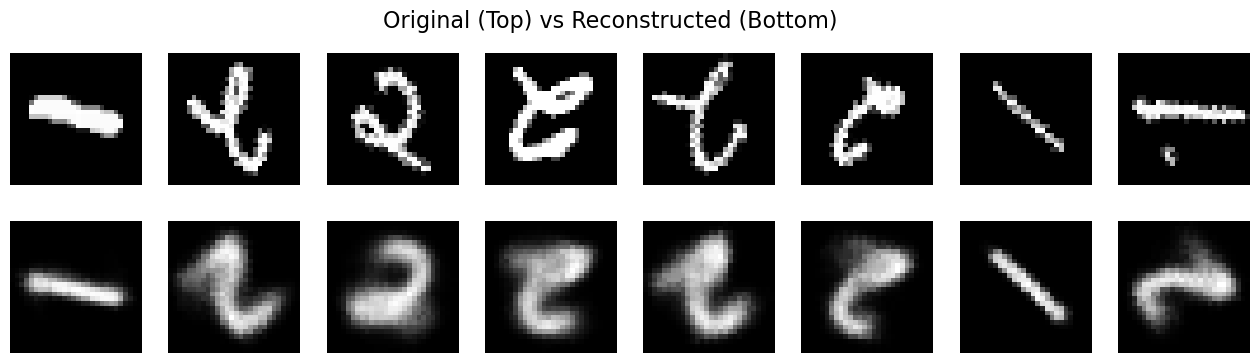

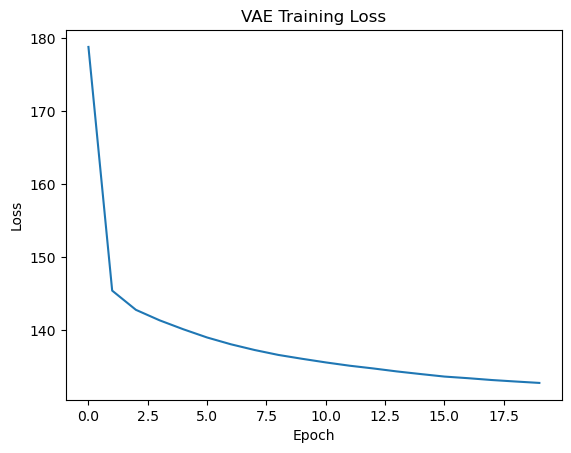

In [6]:
vae.eval()
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)
with torch.no_grad():
    recon, _, _ = vae(images)

n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Original (Top) vs Reconstructed (Bottom)', fontsize=16)
plt.show()

plt.figure()
plt.plot(vae_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Task 2: Supervised Symmetry Discovery

We now learn a transformation in the latent space of the trained VAE that maps it to the 30 degrees anticlockwise rotated version of itself. To do this we train an MLP to that learns this transformation on paris of latent vectors

In [7]:
class LatentPairDataset(Dataset):
    def __init__(self, vae, dataset, angles, device='cpu'):
        self.vae = vae
        self.dataset = dataset
        self.angles = angles
        self.device = device
        self.num_rotations = len(angles)
        
    def __len__(self):
        return len(self.dataset) // self.num_rotations
    
    def __getitem__(self, idx):
        rot_idx = random.randint(0, self.num_rotations - 2)
        base_index = idx * self.num_rotations + rot_idx

        img_orig, _ = self.dataset[base_index]
        img_orig = img_orig.unsqueeze(0).to(self.device)
        with torch.no_grad():
            mu_orig, _ = self.vae.encode(img_orig)
        latent_orig = mu_orig.squeeze(0)
        
        # Get the latent vector for a 30 degree rotated version
        target_index = base_index + 1
        img_rot, _ = self.dataset[target_index]
        img_rot = img_rot.unsqueeze(0).to(self.device)
        with torch.no_grad():
            mu_rot, _ = self.vae.encode(img_rot)
        latent_target = mu_rot.squeeze(0)
        return latent_orig, latent_target

class LatentMLP(nn.Module):
    def __init__(self, latent_dim=50):
        super(LatentMLP, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_mlp(mlp, dataloader, optimizer, epochs=10, device='cuda'):
    mlp.train()
    mlp.to(device)
    criterion = nn.MSELoss()
    losses = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        pbar = tqdm(dataloader)
        for latent_orig, latent_target in pbar:
            latent_orig = latent_orig.to(device)
            latent_target = latent_target.to(device)
            optimizer.zero_grad()
            pred = mlp(latent_orig)
            loss = criterion(pred, latent_target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_description(f"Loss: {loss.item():.4f}")
        avg_loss = train_loss / len(dataloader)
        losses.append(avg_loss)
        print(f'MLP Epoch: {epoch} Average Loss: {avg_loss:.4f}')
    return losses


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 0 Average Loss: 0.4397


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 1 Average Loss: 0.0698


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 2 Average Loss: 0.0555


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 3 Average Loss: 0.0503


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 4 Average Loss: 0.0469


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 5 Average Loss: 0.0453


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 6 Average Loss: 0.0428


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 7 Average Loss: 0.0419


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 8 Average Loss: 0.0399


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 9 Average Loss: 0.0393


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 10 Average Loss: 0.0386


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 11 Average Loss: 0.0385


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 12 Average Loss: 0.0369


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 13 Average Loss: 0.0371


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 14 Average Loss: 0.0361


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 15 Average Loss: 0.0354


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 16 Average Loss: 0.0354


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 17 Average Loss: 0.0338


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 18 Average Loss: 0.0351


  0%|          | 0/50 [00:00<?, ?it/s]

MLP Epoch: 19 Average Loss: 0.0340


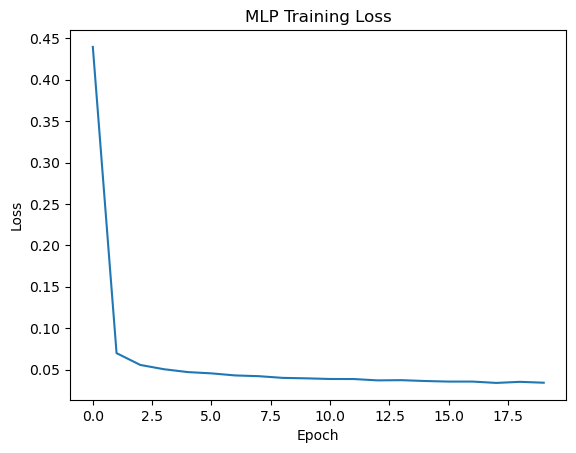

In [8]:
latent_dataset = LatentPairDataset(vae, rotated_dataset, angles, device=device)
latent_dataloader = DataLoader(latent_dataset, batch_size=256, shuffle=True)

mlp = LatentMLP(latent_dim=2)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=1e-3)
mlp_losses = train_mlp(mlp, latent_dataloader, optimizer_mlp, epochs=20, device=device)

plt.figure()
plt.plot(mlp_losses)
plt.title('MLP Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

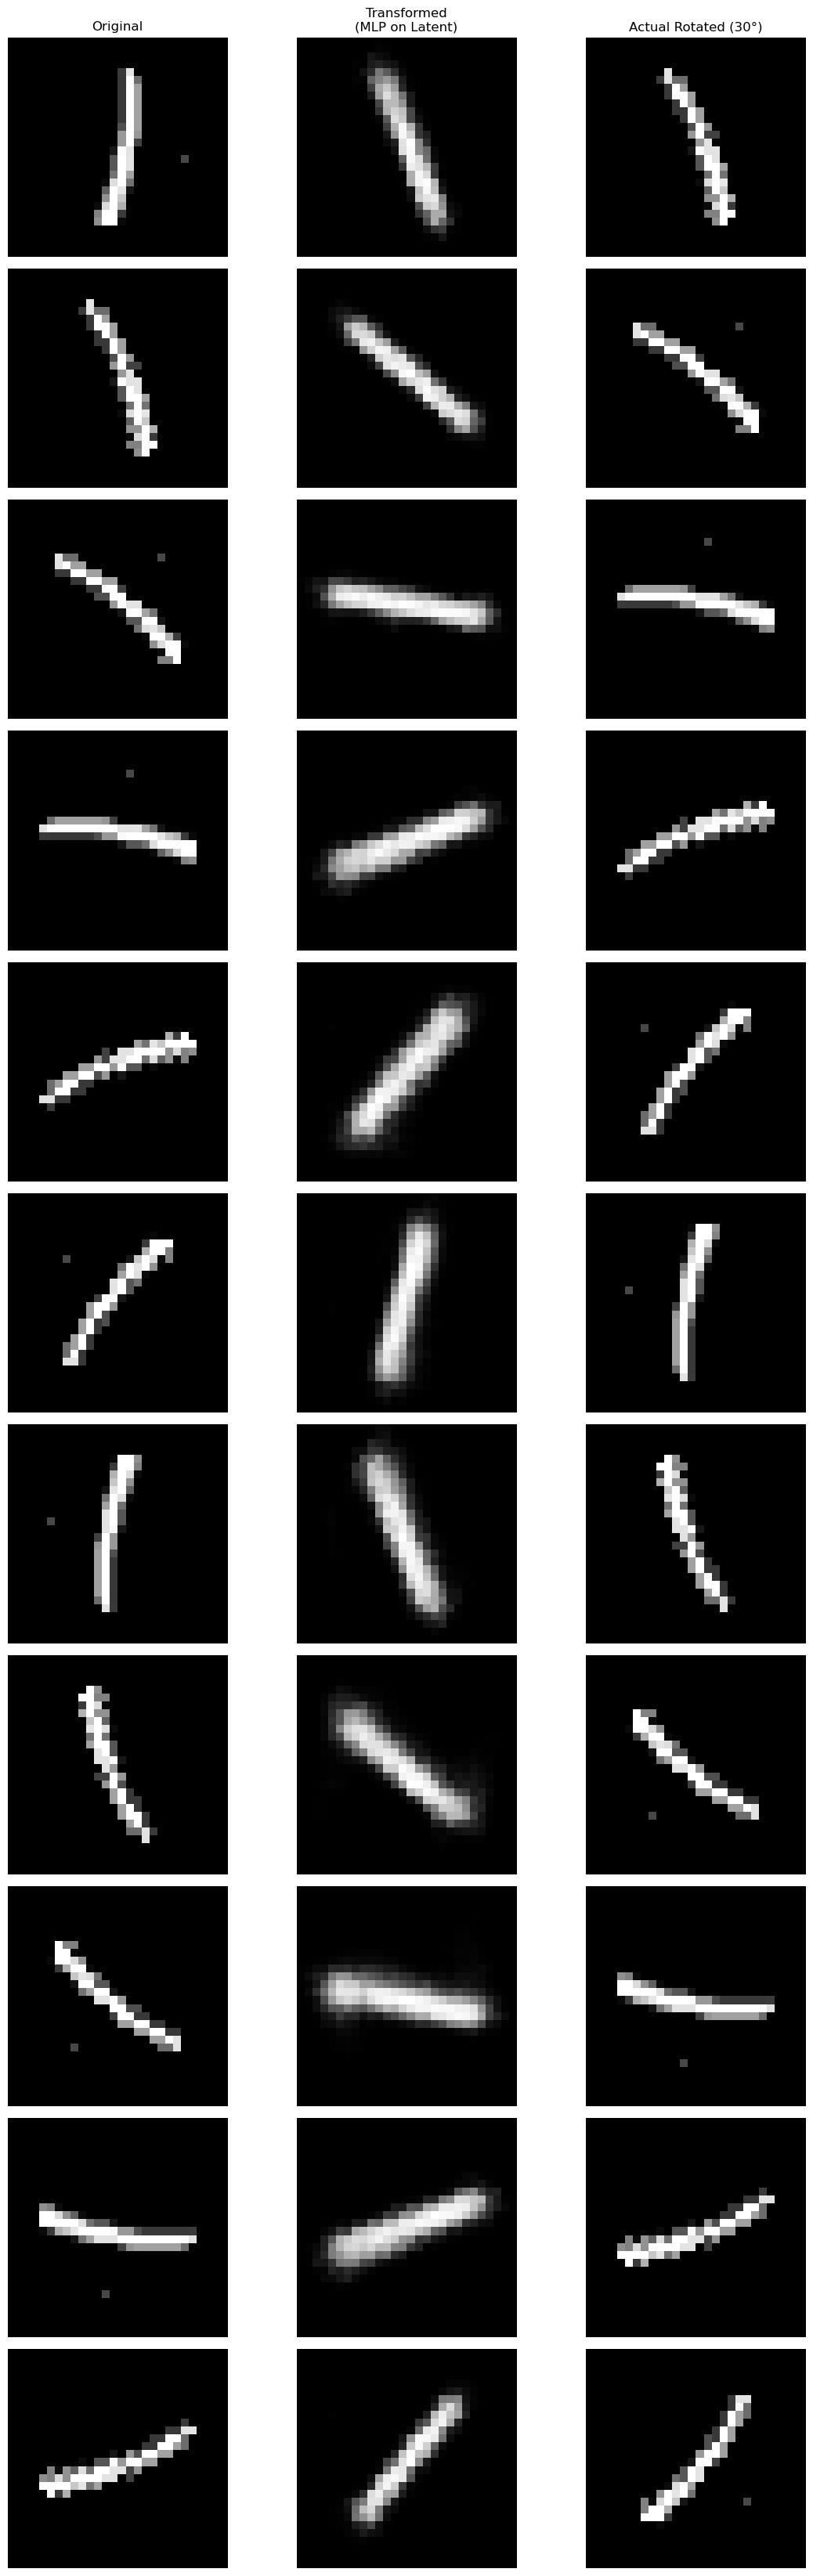

In [9]:
vae.eval()
mlp.eval()
angles = list(range(0, 360, 30))
num_rotations = len(angles)

fig, axs = plt.subplots(11, 3, figsize=(12, 11 * 3))

idx = random.randint(0, len(rotated_dataset) // 12 - 1)

for i in range(11):
    base_index = idx * 12 + i
    img_orig, _ = rotated_dataset[base_index]
    img_rot_actual, _ = rotated_dataset[base_index + 1]
    
    img_orig_tensor = img_orig.unsqueeze(0).to(device)
    with torch.no_grad():
        mu, _ = vae.encode(img_orig_tensor)
        latent_transformed = mlp(mu)
        img_transformed = vae.decode(latent_transformed)
    
    img_orig_np = img_orig.cpu().squeeze().numpy()
    img_transformed_np = img_transformed.cpu().squeeze().numpy()
    img_rot_actual_np = img_rot_actual.cpu().squeeze().numpy()

    axs[i, 0].imshow(img_orig_np, cmap='gray')
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Original')
    
    axs[i, 1].imshow(img_transformed_np, cmap='gray')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Transformed\n(MLP on Latent)')
    
    axs[i, 2].imshow(img_rot_actual_np, cmap='gray')
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 2].set_title('Actual Rotated (30°)')

plt.tight_layout()
plt.show()

## Task 3: Unsupervised Symmetry Discovery

We will first learn an infinitesimal transformation in latent space
such that the classifier (oracle) output remains invariant. In other words,
for a latent vector $\mathbf{z}$ the transformation

$$
\mathbf{z}' = \mathbf{z} + \varepsilon\, g(\mathbf{z})
$$

must satisfy

$$
\psi(\mathbf{z}') \approx \psi(\mathbf{z})\,. \tag{Invariance}
$$

The loss used for training the generator \(g\) is

$$
L_{\text{inv}} = \frac{1}{m\varepsilon^2}\sum_{i=1}^{m}\left[\psi(\mathbf{z}_i+\varepsilon\,g(\mathbf{z}_i)) - \psi(\mathbf{z}_i)\right]^2,
$$

together with a normalization term that forces

$$
\|g(\mathbf{z}_i)\| \approx 1.
$$

### Data Loading and Preprocessing

In [10]:
class LatentVecDataset(Dataset):
    def __init__(self, vae, dataset, device='cpu'):
        self.vae = vae
        self.dataset = dataset
        self.device = device
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):

        img, label = self.dataset[idx]
        img = img.unsqueeze(0).to(self.device)
        with torch.no_grad():
            mu, _ = self.vae.encode(img)
        latent = mu.squeeze(0)
        
        return latent, label - 1
    
class LatentClassifier(nn.Module):
    def __init__(self, dim=2, latent_dim=16):
        super(LatentClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1)
        )

    def forward(self, z):
        return self.classifier(z)

def evaluate_classifier(classifier, dataloader, device='cuda'):
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for latents, labels in dataloader:
            latents = latents.to(device)
            labels = labels.to(device)
            logits = classifier(latents)
            predictions = (torch.sigmoid(logits) > 0.5).float().flatten()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train_classifier(classifier, train_loader, test_loader, optimizer, epochs=10, device='cuda'):
    classifier.train()
    classifier.to(device)
    criterion = nn.BCELoss()
    losses = []
    for epoch in range(epochs):
        classifier.train()
        train_loss = 0
        pbar = tqdm(train_loader)
        for latents, labels in pbar:
            latents = latents.to(device)
            labels = labels.unsqueeze(1).to(device, torch.float32)
            optimizer.zero_grad()
            logits = classifier(latents)
            loss = criterion(torch.sigmoid(logits), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_description(f"Loss: {loss.item():.4f}")
        avg_loss = train_loss / len(train_loader)
        losses.append(avg_loss)
        test_acc = evaluate_classifier(classifier, test_loader, device)
        print(f'Epoch {epoch+1}: Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    return losses

### Oracle $(\psi)$ training

we train a classifier $\psi: \mathbb{R}^{2}\rightarrow \mathbb{R}$ that predicts
the label. The classifier is trained with a sigmoid
output and binary cross-entropy loss

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1: Loss: 0.4216, Test Accuracy: 0.9803


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2: Loss: 0.1561, Test Accuracy: 0.9808


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3: Loss: 0.1012, Test Accuracy: 0.9811


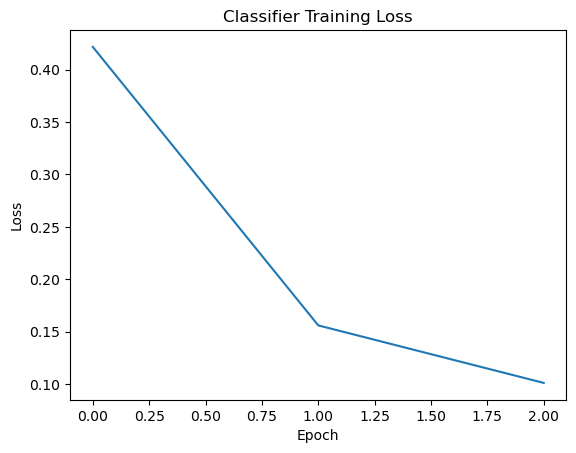

In [11]:
latent_vec_dataset = LatentVecDataset(vae, rotated_dataset, device)

train_size  = int(0.8 * len(latent_vec_dataset))
test_size = len(latent_vec_dataset) - train_size
train_dataset, test_dataset = random_split(latent_vec_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

classifier = LatentClassifier(dim=2, latent_dim=256)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=1e-3)
classifier_losses = train_classifier(classifier, train_dataloader, test_dataloader, optimizer_classifier, epochs=3, device=device)

plt.figure()
plt.plot(classifier_losses)
plt.title('Classifier Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Symmetry generator network $g(\mathbf{z})$

We now train a neural network $g$ to learn an infinitesimal transformation $\mathbf{z}' = \mathbf{z} + \varepsilon\, g(\mathbf{z})$ on the 2D latent space that leaves the oracle's output invariant $\psi(\mathbf{z}') \approx \psi(\mathbf{z})$

The loss function for invariance from the paper is defined as:

$$
L_{\text{inv}} = \frac{1}{m\varepsilon^2}\sum_{i=1}^{m}\left[\psi(\mathbf{z}_i+\varepsilon\,g(\mathbf{z}_i)) - \psi(\mathbf{z}_i)\right]^2
$$

We also add a normalization loss to force

$$
\|g(\mathbf{z}_i)\| \approx 1\,. \tag{11}
$$

For this experiment we use $\varepsilon = 10^{-3}$

$$
L = L_{\text{inv}} + \lambda_{\text{norm}}\,L_{\text{norm}}
$$

where

$$
L_{\text{inv}} = \frac{1}{m\varepsilon^2}\sum_{i=1}^{m}\left[\psi(\mathbf{z}_i+\varepsilon\,g(\mathbf{z}_i)) - \psi(\mathbf{z}_i)\right]^2,
$$

and

$$
L_{\text{norm}} = \frac{1}{m}\sum_{i=1}^{m}\left(\|g(\mathbf{z}_i)\| - 1\right)^2 + \frac{1}{m}\sum_{i=1}^{m}\left(\|g(\mathbf{z}_i)\| - \overline{\|g(\mathbf{z}_i)\|}\right)^2.
$$

Here, $\lambda_{\text{norm}}$ is set to 1

We use the encoder (frozen) to obtain latent representations \( \mathbf{z} \) and then update \(g\).

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim=2):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

    def forward(self, z):
        return self.net(z)

eps = 1e-3
lr = 1e-3
lambda_norm = 1.0
epochs = 15

generator = Generator().to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
mse_loss = nn.MSELoss()

vae.eval()
classifier.eval()

generator_loader = DataLoader(latent_vec_dataset, batch_size=256, shuffle=True)

for epoch in range(epochs):
    generator.train()
    total_inv_loss = 0
    total_norm_loss = 0
    total_loss = 0
    pbar = tqdm(generator_loader)
    for z, _ in pbar:
        with torch.no_grad():
            psi_z = classifier(z)
        # Compute g(z)
        g_z = generator(z)
        # Invariance: psi(z + eps*g(z)) should equal psi(z)
        psi_z_trans = classifier(z + eps * g_z)
        inv_loss = mse_loss(psi_z_trans, psi_z) / (eps**2)
        
        # Normalization loss: force ||g(z)|| ~ 1 and similar among batch
        norms = torch.norm(g_z, dim=1)
        norm_loss = mse_loss(norms, torch.ones_like(norms)) + mse_loss(norms, norms.mean().expand_as(norms))
        
        loss = inv_loss + lambda_norm * norm_loss
        
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()
        
        total_inv_loss += inv_loss.item()
        total_norm_loss += norm_loss.item()
        total_loss += loss.item()
        pbar.set_description(f"Loss: {loss.item()}")
    print(f"Epoch [{epoch+1}/{epochs}] Total Loss: {total_loss/len(generator_loader):.4f}  Inv: {total_inv_loss/len(generator_loader):.4f}  Norm: {total_norm_loss/len(generator_loader):.4f}")

  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [1/15] Total Loss: 0.7880  Inv: 0.2105  Norm: 0.5774


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [2/15] Total Loss: 0.4318  Inv: 0.0839  Norm: 0.3479


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [3/15] Total Loss: 0.3294  Inv: 0.0610  Norm: 0.2683


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [4/15] Total Loss: 0.2774  Inv: 0.0534  Norm: 0.2241


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [5/15] Total Loss: 0.2398  Inv: 0.0526  Norm: 0.1872


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [6/15] Total Loss: 0.2049  Inv: 0.0548  Norm: 0.1500


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [7/15] Total Loss: 0.1827  Inv: 0.0600  Norm: 0.1227


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [8/15] Total Loss: 0.1664  Inv: 0.0634  Norm: 0.1029


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [9/15] Total Loss: 0.1572  Inv: 0.0663  Norm: 0.0909


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [10/15] Total Loss: 0.1499  Inv: 0.0662  Norm: 0.0838


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [11/15] Total Loss: 0.1433  Inv: 0.0644  Norm: 0.0789


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [12/15] Total Loss: 0.1373  Inv: 0.0624  Norm: 0.0749


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [13/15] Total Loss: 0.1333  Inv: 0.0618  Norm: 0.0715


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [14/15] Total Loss: 0.1300  Inv: 0.0614  Norm: 0.0686


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [15/15] Total Loss: 0.1281  Inv: 0.0617  Norm: 0.0664


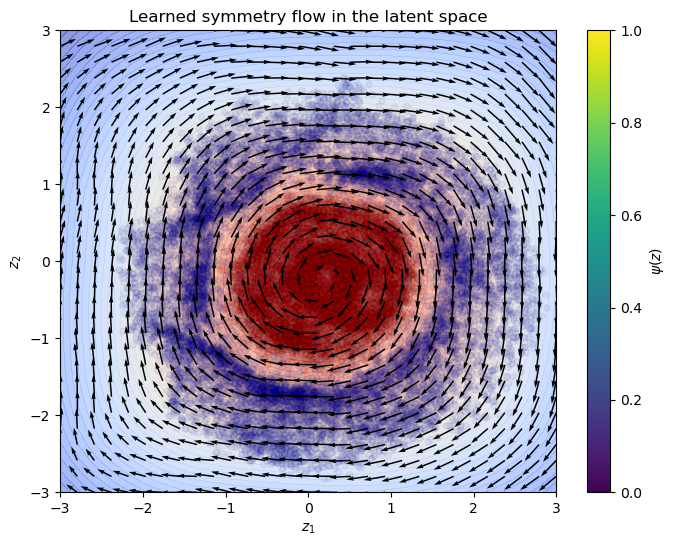

In [13]:
n_points = 30
z1 = np.linspace(-3, 3, n_points)
z2 = np.linspace(-3, 3, n_points)
Z1, Z2 = np.meshgrid(z1, z2)
grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

with torch.no_grad():
    psi_grid = classifier(grid_tensor)
    g_grid = generator(grid_tensor)

psi_grid = psi_grid.cpu().numpy().reshape(Z1.shape)
g1 = g_grid[:,0].cpu().numpy().reshape(Z1.shape)
g2 = g_grid[:,1].cpu().numpy().reshape(Z1.shape)

# Get latent representations for test images and their labels
all_z = []
all_labels = []
for z, labels in test_dataloader:
    all_z.append(z.cpu().numpy())
    # Map: digit 1 -> 0, digit 2 -> 1
    all_labels.append(labels)
all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

plt.figure(figsize=(8,6))
plt.contourf(Z1, Z2, psi_grid, levels=50, cmap='coolwarm', alpha=0.6)
plt.scatter(all_z[:,0], all_z[:,1], c=all_labels, cmap='bwr', edgecolor='k', s=20, alpha=0.05)
plt.quiver(Z1, Z2, g1, g2, color='black', width=0.003, scale=20)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Learned symmetry flow in the latent space')
plt.colorbar(label='$\psi(z)$')
plt.show()

#### Interpolation along the learned symmetry

To visualize the learned symmetry in $g$ we will repeadtly apply the transformation $z' = z + \epsilon g(z)$ along the flow lines
We will now sample along the learned lines

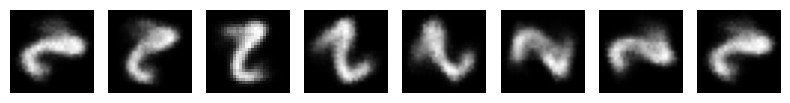

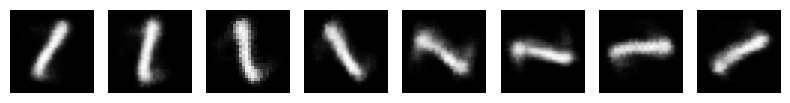

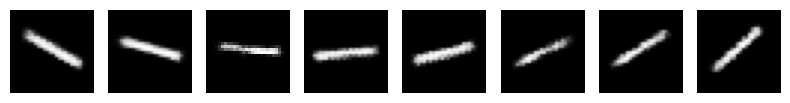

In [14]:
def simulate_streamline(z0, generator, num_steps=4, step_size=1e-3, jumps=10):
    generator.eval()
    z0_tensor = z0.unsqueeze(0).to(device)
    
    # Simulate forward direction
    # z_forward = [z0_tensor.clone()]
    # z_curr = z0_tensor.clone()
    # with torch.no_grad():
    #     for _ in range(num_steps):
    #         dz = generator(z_curr)
    #         z_curr = z_curr + step_size * dz
    #         z_forward.append(z_curr.clone())
    
    # Simulate backward direction
    z_backward = []
    z_curr = z0_tensor.clone()
    with torch.no_grad():
        for _ in range(num_steps):
            for _ in range(jumps):
                dz = generator(z_curr)
                z_curr = z_curr - step_size * dz
            z_backward.append(z_curr.clone())
    z_backward.reverse()
    
    streamline = z_backward
    return streamline

s1, s2, s3 = torch.tensor([
    [0, 0.75], # the inner cluster
    [0, 1], # the intersection of the clusters
    [0, 2] # the 
])
num_steps = 8 
jumps = 1000
streamline1 = simulate_streamline(s1, generator, num_steps=num_steps, step_size=eps, jumps=jumps)
streamline2 = simulate_streamline(s2, generator, num_steps=num_steps, step_size=eps, jumps=jumps)
streamline3 = simulate_streamline(s3, generator, num_steps=num_steps, step_size=eps, jumps=jumps)

# Decode latent codes to images
def decode_streamline(streamline, vae):
    vae.eval()
    decoded_imgs = []
    with torch.no_grad():
        for z in streamline:
            x_recon = vae.decode(z).cpu().numpy().reshape(28, 28)
            decoded_imgs.append(x_recon)
    return decoded_imgs

decoded1 = decode_streamline(streamline1, vae)
decoded2 = decode_streamline(streamline2, vae)
decoded3 = decode_streamline(streamline3, vae)

def plot_streamline(decoded_imgs):
    n = len(decoded_imgs)
    plt.figure(figsize=(n, 6))
    for i, img in enumerate(decoded_imgs):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_streamline(decoded1)
plot_streamline(decoded2)
plot_streamline(decoded3)


## $l=3$ latent variables and $N_{g}=2$ generators

We now learn 2 generators in such a way so that they learn unique symmetries by using the orthogonal loss from the paper

$$
L_{\text{ortho}} = \frac{1}{m}\sum_{i=1}^{m}\Bigl[g^1(\mathbf{z}_i)\cdot g^2(\mathbf{z}_i)\Bigr]^2
$$

In [15]:
dataloader = DataLoader(rotated_dataset, batch_size=256, shuffle=True)

vae3 = VAE(latent_dim=3)
optimizer = torch.optim.Adam(vae3.parameters(), lr=1e-3)
vae_losses = train_vae(vae3, dataloader, optimizer, epochs=20, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 0 Average loss: 169.8917


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 1 Average loss: 134.2595


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 2 Average loss: 128.1052


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 3 Average loss: 125.5718


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 4 Average loss: 124.2105


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 5 Average loss: 123.3110


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 6 Average loss: 122.6910


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 7 Average loss: 122.1979


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 8 Average loss: 121.7690


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 9 Average loss: 121.4470


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 10 Average loss: 121.1289


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 11 Average loss: 120.9239


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 12 Average loss: 120.6563


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 13 Average loss: 120.4428


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 14 Average loss: 120.2510


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 15 Average loss: 120.1030


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 16 Average loss: 119.9762


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 17 Average loss: 119.8179


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 18 Average loss: 119.7189


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch: 19 Average loss: 119.5830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1: Loss: 0.3363, Test Accuracy: 0.9553


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2: Loss: 0.1327, Test Accuracy: 0.9801


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3: Loss: 0.0879, Test Accuracy: 0.9818


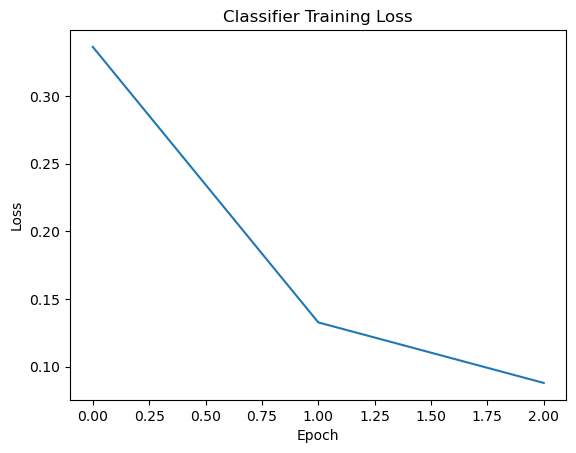

In [16]:
latent_vec_dataset = LatentVecDataset(vae3, rotated_dataset, device)

train_size  = int(0.8 * len(latent_vec_dataset))
test_size = len(latent_vec_dataset) - train_size
train_dataset, test_dataset = random_split(latent_vec_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

classifier3 = LatentClassifier(dim=3, latent_dim=256)
optimizer_classifier = torch.optim.Adam(classifier3.parameters(), lr=1e-3)
classifier_losses = train_classifier(classifier3, train_dataloader, test_dataloader, optimizer_classifier, epochs=3, device=device)

plt.figure()
plt.plot(classifier_losses)
plt.title('Classifier Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [81]:
class Generator(nn.Module):
    def __init__(self, latent_dim=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

    def forward(self, z):
        return self.net(z)

eps = 1e-3
lr = 1e-3
lambda_norm = 1.0
lambda_ortho = 0.5
epochs = 20

generator1 = Generator().to(device)
generator2 = Generator().to(device)
gen_optimizer = torch.optim.Adam(list(generator1.parameters()) + list(generator2.parameters()), lr=lr)
mse_loss = nn.MSELoss()

vae3.eval()
classifier3.eval()

generator_loader = DataLoader(latent_vec_dataset, batch_size=256, shuffle=True)

for epoch in range(epochs):
    generator1.train()
    generator2.train()
    total_inv_loss = 0
    total_norm_loss = 0
    total_ortho_loss = 0
    total_loss = 0
    pbar = tqdm(generator_loader)
    for z, _ in pbar:

        with torch.no_grad():
            psi_z = classifier3(z)

        g_z1 = generator1(z)
        g_z2 = generator2(z)

        # Invariance: psi(z + eps*g(z)) should equal psi(z)
        psi_z1_trans = classifier3(z + eps * g_z1)
        inv_loss1 = mse_loss(psi_z1_trans, psi_z) / (eps**2)
        psi_z2_trans = classifier3(z + eps * g_z2)
        inv_loss2 = mse_loss(psi_z2_trans, psi_z) / (eps**2)
        
        # Normalization loss: force ||g(z)|| ~ 1 and similar among batch
        norms1 = torch.norm(g_z1, dim=1)
        norm_loss1 = mse_loss(norms1, torch.ones_like(norms1)) + mse_loss(norms1, norms1.mean().expand_as(norms1))
        norms2 = torch.norm(g_z2, dim=1)
        norm_loss2 = mse_loss(norms2, torch.ones_like(norms2)) + mse_loss(norms2, norms2.mean().expand_as(norms2))

        ortho_loss = mse_loss(torch.sum(g_z1 * g_z2, dim=1), torch.zeros(g_z1.size(0)).to(device))
        
        loss = inv_loss1 + inv_loss2 + lambda_norm * (norm_loss1 + norm_loss2) + lambda_ortho * ortho_loss
        
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()
        
        total_inv_loss += (inv_loss1 + inv_loss2).item()
        total_norm_loss += (norm_loss1 + norm_loss2).item()
        total_ortho_loss += ortho_loss.item()
        total_loss += loss.item()
        pbar.set_description(f"Loss: {loss.item()}")
    print(f"Epoch [{epoch+1}/{epochs}] Total Loss: {total_loss/len(generator_loader):.4f}  Inv: {total_inv_loss/len(generator_loader):.4f}  Norm: {total_norm_loss/len(generator_loader):.4f} Ortho: {ortho_loss/len(generator_loader):.4f}")

  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [1/20] Total Loss: 1.0023  Inv: 0.4883  Norm: 0.5026 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [2/20] Total Loss: 0.3164  Inv: 0.1075  Norm: 0.1995 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [3/20] Total Loss: 0.2127  Inv: 0.0869  Norm: 0.1161 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [4/20] Total Loss: 0.1588  Inv: 0.0767  Norm: 0.0699 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [5/20] Total Loss: 0.1351  Inv: 0.0749  Norm: 0.0492 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [6/20] Total Loss: 0.1214  Inv: 0.0747  Norm: 0.0377 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [7/20] Total Loss: 0.1118  Inv: 0.0728  Norm: 0.0316 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [8/20] Total Loss: 0.1035  Inv: 0.0693  Norm: 0.0278 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [9/20] Total Loss: 0.0969  Inv: 0.0666  Norm: 0.0246 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [10/20] Total Loss: 0.0914  Inv: 0.0644  Norm: 0.0218 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [11/20] Total Loss: 0.0875  Inv: 0.0631  Norm: 0.0198 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [12/20] Total Loss: 0.0851  Inv: 0.0623  Norm: 0.0183 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [13/20] Total Loss: 0.0833  Inv: 0.0617  Norm: 0.0174 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [14/20] Total Loss: 0.0818  Inv: 0.0611  Norm: 0.0167 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [15/20] Total Loss: 0.0806  Inv: 0.0605  Norm: 0.0162 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [16/20] Total Loss: 0.0796  Inv: 0.0601  Norm: 0.0157 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [17/20] Total Loss: 0.0787  Inv: 0.0596  Norm: 0.0154 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [18/20] Total Loss: 0.0778  Inv: 0.0591  Norm: 0.0150 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [19/20] Total Loss: 0.0768  Inv: 0.0586  Norm: 0.0145 Ortho: 0.0000


  0%|          | 0/596 [00:00<?, ?it/s]

Epoch [20/20] Total Loss: 0.0757  Inv: 0.0581  Norm: 0.0140 Ortho: 0.0000


In [80]:
import plotly.graph_objects as go
import pandas as pd

all_z = []
all_labels = []
for z, labels in test_dataloader:
    all_z.append(z.cpu().numpy())
    labels = labels.cpu().numpy().astype(np.int32)
    all_labels.append(labels)
all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

df = pd.DataFrame({
    "z1": all_z[:, 0],
    "z2": all_z[:, 1],
    "z3": all_z[:, 2],
    "label": all_labels
})

fig_scatter = go.Figure()

for lbl, color in zip([0, 1], ['blue', 'red']):
    df_sub = df[df['label'] == lbl]
    fig_scatter.add_trace(go.Scatter3d(
        x=df_sub["z1"],
        y=df_sub["z2"],
        z=df_sub["z3"],
        mode='markers',
        marker=dict(size=3, color=color, opacity=0.2),
        name=f'Digit {1 if lbl==0 else 2}'
    ))

fig_scatter.update_layout(
    title="3D Latents",
    scene=dict(
        xaxis_title="z1",
        yaxis_title="z2",
        zaxis_title="z3"
    )
)
fig_scatter.show()


#### Generator 1 Symmetry

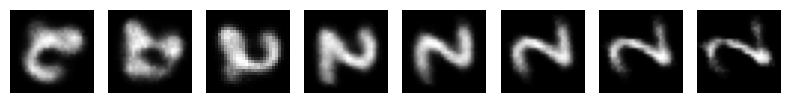

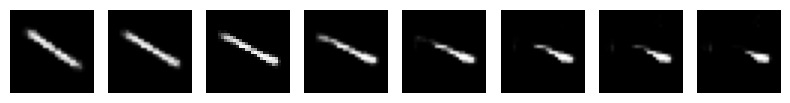

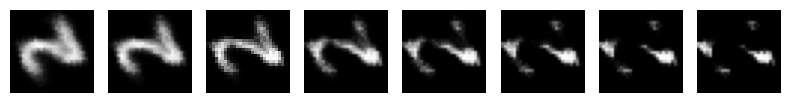

In [106]:
def simulate_streamline(z0, generator, num_steps=4, step_size=1e-4, jumps=10):
    generator.eval()
    z0_tensor = z0.unsqueeze(0).to(device)
    
    # Simulate forward direction
    # z_forward = [z0_tensor.clone()]
    # z_curr = z0_tensor.clone()
    # with torch.no_grad():
    #     for _ in range(num_steps):
    #         dz = generator(z_curr)
    #         z_curr = z_curr + step_size * dz
    #         z_forward.append(z_curr.clone())
    
    # Simulate backward direction
    z_backward = []
    z_curr = z0_tensor.clone()
    with torch.no_grad():
        for _ in range(num_steps):
            for _ in range(jumps):
                dz = generator(z_curr)
                z_curr = z_curr + step_size * dz
            z_backward.append(z_curr.clone())
    
    streamline = z_backward
    return streamline

s1, s2, s3 = torch.randn(3, 3, device=device)
# s1, s2, s3 = torch.tensor([
#     [-2.1294, -1.4370, -0.5216],
#     [-0.9265,  0.3382, -1.4333],
#     [ 0.7534, -0.5581, -1.8138]
# ], device=device)
num_steps = 8
jumps = 500
step_size = 1e-3
streamline1 = simulate_streamline(s1, generator1, num_steps=num_steps, step_size=step_size, jumps=jumps)
streamline2 = simulate_streamline(s2, generator1, num_steps=num_steps, step_size=step_size, jumps=jumps)
streamline3 = simulate_streamline(s3, generator1, num_steps=num_steps, step_size=step_size, jumps=jumps)

# Decode latent codes to images
def decode_streamline(streamline, vae):
    vae.eval()
    decoded_imgs = []
    with torch.no_grad():
        for z in streamline:
            x_recon = vae.decode(z).cpu().numpy().reshape(28, 28)
            decoded_imgs.append(x_recon)
    return decoded_imgs

decoded1 = decode_streamline(streamline1, vae3)
decoded2 = decode_streamline(streamline2, vae3)
decoded3 = decode_streamline(streamline3, vae3)

def plot_streamline(decoded_imgs):
    n = len(decoded_imgs)
    plt.figure(figsize=(n, 6))
    for i, img in enumerate(decoded_imgs):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_streamline(decoded1)
plot_streamline(decoded2)
plot_streamline(decoded3)

#### Generator 2 Symmetry

This shows the rotational symmetry of the digits

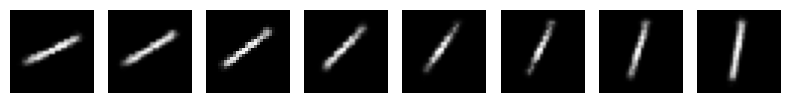

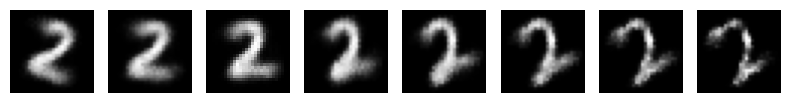

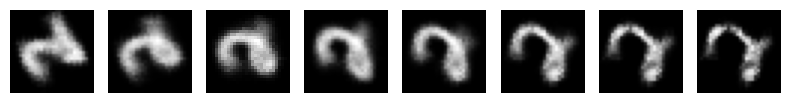

In [103]:
def simulate_streamline(z0, generator, num_steps=4, step_size=1e-4, jumps=10):
    generator.eval()
    z0_tensor = z0.unsqueeze(0).to(device)
    
    # Simulate forward direction
    # z_forward = [z0_tensor.clone()]
    # z_curr = z0_tensor.clone()
    # with torch.no_grad():
    #     for _ in range(num_steps):
    #         dz = generator(z_curr)
    #         z_curr = z_curr + step_size * dz
    #         z_forward.append(z_curr.clone())
    
    # Simulate backward direction
    z_backward = []
    z_curr = z0_tensor.clone()
    with torch.no_grad():
        for _ in range(num_steps):
            for _ in range(jumps):
                dz = generator(z_curr)
                z_curr = z_curr + step_size * dz
            z_backward.append(z_curr.clone())
    
    streamline = z_backward
    return streamline

s1, s2, s3 = torch.tensor([
    [-2.1294, -1.4370, -0.5216],
    [-0.9265,  0.3382, -1.4333],
    [ 0.7534, -0.5581, -1.8138]
], device=device)
num_steps = 8
jumps = 500
step_size = 1e-3
streamline1 = simulate_streamline(s1, generator2, num_steps=num_steps, step_size=step_size, jumps=jumps)
streamline2 = simulate_streamline(s2, generator2, num_steps=num_steps, step_size=step_size, jumps=jumps)
streamline3 = simulate_streamline(s3, generator2, num_steps=num_steps, step_size=step_size, jumps=jumps)

# Decode latent codes to images
def decode_streamline(streamline, vae):
    vae.eval()
    decoded_imgs = []
    with torch.no_grad():
        for z in streamline:
            x_recon = vae.decode(z).cpu().numpy().reshape(28, 28)
            decoded_imgs.append(x_recon)
    return decoded_imgs

decoded1 = decode_streamline(streamline1, vae3)
decoded2 = decode_streamline(streamline2, vae3)
decoded3 = decode_streamline(streamline3, vae3)

def plot_streamline(decoded_imgs):
    n = len(decoded_imgs)
    plt.figure(figsize=(n, 6))
    for i, img in enumerate(decoded_imgs):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_streamline(decoded1)
plot_streamline(decoded2)
plot_streamline(decoded3)